# 우주 암석 분류
## 이미지 식별 머신을 위한 데이터 준비
필요할 라이브러리 임포트부터 시작.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms, models
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 데이터 디렉터리, 분할 비율, 변환 방법 설정

In [2]:
data_dir = './data'  # 이미지 데이터 디렉터리
valid_size = 0.2  # 세트 분할 비율(validation set)

In [3]:
# 이미지 데이터 변환 방법 지정
t_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor()
])

In [4]:
# 지정한 이미지 데이터 변환 방법 확인
print(t_transforms)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


## 데이터 로딩 함수 작성
> trainloadr와 testloader를 만듭니다.

1. 학습 데이터셋 및 테스트 데이터셋의 디렉터리 및 변환 방식 지정.
2. 데이터셋을 섞기(shuffle) 위해, 인덱스를 만들어 랜덤하게 셔플.
3. 분할 비율(`valid_size`)에 따른 지점의 인덱스 값(split)을 계산.
4. split을 기준으로 학습 데이터 인덱스 리스트와 테스트 인덱스 리스트로 분할.
5. 데이터셋의 샘플러 및 로더를 생성하고 확인.

In [5]:
# datasets.ImageFolder를 사용해 학습 데이터(train_data)와 테스트 데이터(test_data) 생성
train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
test_data = datasets.ImageFolder(data_dir, transform=t_transforms)

print(train_data)  # 학습 데이터 형식 확인
print(len(train_data), len(test_data))  # 각 데이터셋 길이 확인

Dataset ImageFolder
    Number of datapoints: 155
    Root location: ./data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
155 155


In [6]:
# train_data 사이즈만큼의 정수값을 갖는 인덱스 리스트 생성
num_train = len(train_data)
indices = list(range(num_train))
print(indices)  # 인덱스 리스트 확인

# 인덱스 리스트를 랜덤하게 셔플
np.random.shuffle(indices)
print(indices)  # 셔플된 인덱스 리스트 확인

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[5, 134, 120, 119, 136, 142, 71, 16, 121, 24, 133, 148, 69, 86, 139, 74, 27, 56, 80, 54, 70, 92, 73, 1, 51, 53, 102, 32, 7, 101, 48, 36, 107, 77, 147, 127, 17, 23, 151, 10, 12, 143, 79, 76, 82, 66, 128, 49, 106, 81, 123, 43, 154, 72, 28, 0, 118, 99, 65, 145, 45, 31, 57, 103, 109, 78, 115, 11, 135, 150, 131, 33, 132, 19, 91, 42, 59, 

In [7]:
# valid_size에 맞는 인덱스를 계산하고 확인
split = int(np.floor(num_train * valid_size))
print(split)

31


In [8]:
# 학습 데이터 인덱스와 테스트 데이터 인덱스 분리
train_idx, test_idx = indices[split:], indices[:split]

print(train_idx)
print(test_idx)

[36, 107, 77, 147, 127, 17, 23, 151, 10, 12, 143, 79, 76, 82, 66, 128, 49, 106, 81, 123, 43, 154, 72, 28, 0, 118, 99, 65, 145, 45, 31, 57, 103, 109, 78, 115, 11, 135, 150, 131, 33, 132, 19, 91, 42, 59, 39, 18, 84, 94, 141, 117, 9, 88, 138, 60, 22, 95, 89, 14, 97, 96, 129, 3, 126, 6, 20, 112, 15, 146, 37, 110, 68, 105, 90, 40, 140, 149, 30, 144, 26, 108, 125, 21, 124, 62, 2, 137, 55, 61, 113, 93, 41, 100, 44, 87, 58, 130, 85, 98, 122, 104, 4, 83, 25, 29, 38, 47, 13, 34, 67, 153, 75, 152, 64, 8, 50, 35, 52, 46, 63, 111, 114, 116]
[5, 134, 120, 119, 136, 142, 71, 16, 121, 24, 133, 148, 69, 86, 139, 74, 27, 56, 80, 54, 70, 92, 73, 1, 51, 53, 102, 32, 7, 101, 48]


In [9]:
# 데이터 샘플링 방식(SubsetRandomSampler) 지정
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# 데이터 loader 생성
trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

# 각 loader의 클래스 확인 - 두 데이터셋에 모두 Basalt와 Highland가 들어가 있으면 알맞게 셔플된 것
# 데이터셋이 저장된 디렉터리의 서브 디렉터리 이름을 자동으로 인식
print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


코드들을 한 데 묶어서 데이터 로드 및 분할을 일체화하는 함수를 생성합니다.

In [10]:
def load_split_train_test(data_dir, valid_size):
    t_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor()
    ])

    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

위에서 생성한 함수를 이용해 trainloader와 testloader를 생성합니다.

In [11]:
trainloader, testloader = load_split_train_test(data_dir, 0.2)

In [12]:
print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


## 이미지 데이터 샘플 탐색
임의의 데이터를 로딩한 후 이미지와 레이블을 반환하는 `get_random_images()` 함수를 작성합니다.

In [13]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    # loader에서 데이터를 한 개씩 꺼내는 iterator 생성
    dataiter = iter(loader)
    images, labels = dataiter.next()

    return images, labels

이제 임의로 5개의 이미지와 레이블을 선택해 표시해봅니다.

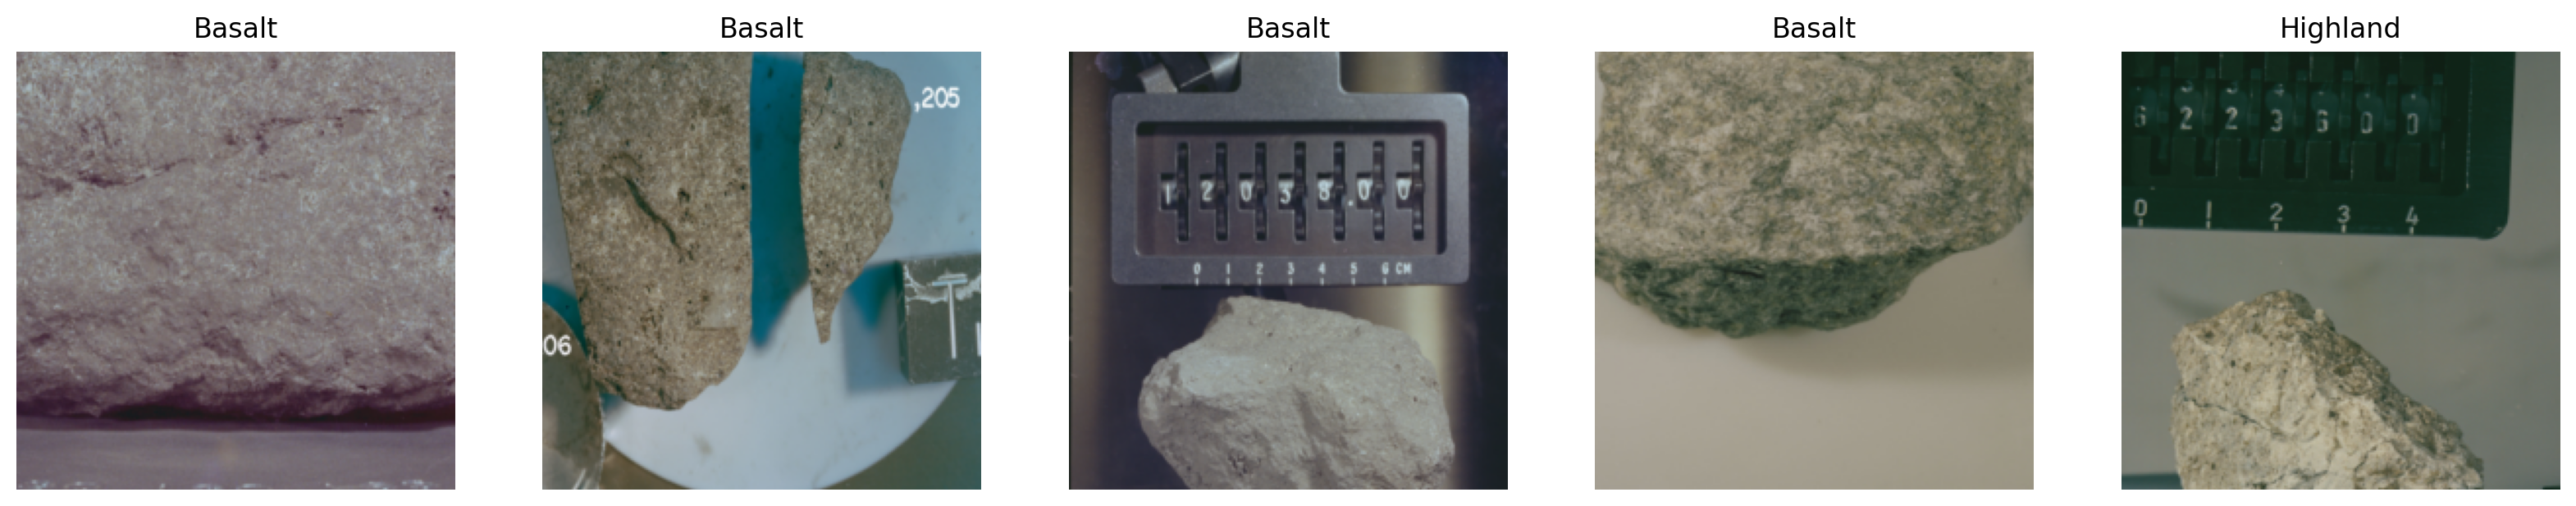

In [14]:
images, labels = get_random_images(5)

# 픽셀 배열을 PIL 형식의 이미지로 변환하고, 이미지 크기 지정
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))

# 학습 데이터의 클래스 리스트 추출
classes = trainloader.dataset.classes

# 이미지 표시
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii + 1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)

plt.show()

## ResNet50 모델 수정
ResNet50 모델에서 FC layer를 수정하는 작업을 합니다.  
먼저 Compute device를 지정합니다. 현재 노트북을 작성 중인 코드스페이스 상에는 GPU를 물리지 않은 상태이기 때문에 CPU로 출력될 겁니다.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [16]:
# resnet50 모델을 로드
model = models.resnet50(pretrained=True)

/workspaces/spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/workspaces/spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


수정을 시작하기에 앞서, 일단 다운받은 ResNet50 모델을 확인해보죠.

In [17]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### FC layer 수정

In [18]:
for param in model.parameters():
    # 전이학습을 위해 모델 가중치 고정(freeze)
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

# 손실 함수 - 크로스엔트로피로 지정
criterion = nn.NLLLoss()

# 옵티마이저 - Adam
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print("Done!")

Done!


In [19]:
# 수정된 모델의 FC layer 확인
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


## FC layer 학습 및 테스트
모델의 학습과 검증을 위한 변수를 먼저 설정합니다.

In [20]:
epochs = 10
print_every = 5
running_loss = 0  # 손실 변수
train_losses, test_losses = [], []
test_accuracy = []

steps = 0  # 학습 단계 변수. 0으로 초기화.

설정한 epoch만큼 모델을 학습시키면서 검증과 평가를 동시에 진행합니다.

In [21]:
for epoch in range(1, epochs + 1):
    for inputs, labels in trainloader:
        steps += 1
        print(f"Training step {steps}")
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # 기존에 학습된 그래디언트 값 초기화
        logps = model.forward(inputs)  # 입력 데이터로 순전파 수행 후 로그 확률을 얻음.
        loss = criterion(logps, labels)  # 손실 계산
        loss.backward()  # 역전파 수행 → 그래디언트 업데이트
        optimizer.step()  # 파라미터 업데이트
        running_loss += loss.item()

        if steps % print_every == 0:
            # 손실과 정확도 변수를 초기화
            test_loss, accuracy = 0, 0
            # 모델을 평가 모드로 전환
            model.eval()
            # 모델 평가 시 그래디언트는 계산하지 않아야 함
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()

                    # 로그 확률로부터 진짜 확률 계산
                    ps = torch.exp(logps)
                    # 가장 큰 확률값과 클래스를 얻음
                    ## (참고 - topk : k번째로 큰 값을 반환)
                    top_p, top_class = ps.topk(1, dim=1)
                    # 레이블들을 top_class와 동일한 형태로 바꿈
                    equals = top_class == labels.view(*top_class.shape)

                    # equlas를 float 텐서로 변환 후, 평균 정확도를 누적/계산
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # 학습 손실값 및 테스트 손실값 추가
            train_losses.append(running_loss / len(trainloader))
            test_losses.append(test_loss / len(testloader))
            test_accuracy.append(accuracy / len(testloader))
            # 학습 손실값, 테스트 손실값, 테스트 정확도 출력
            print(
                f"Epoch {epoch}/{epochs}: "
                f"Train loss: {running_loss / print_every:.3f}.. "
                f"Test loss: {test_loss / len(testloader):.3f}.. "
                f"Test accuracy: {accuracy / len(testloader):.3f}\n"
            )
            
            # 학습 손실 초기화
            running_loss = 0
            # 모델을 학습 모드로 전환
            model.train()
            break


Training step 1
Training step 2
Training step 3
Training step 4
Training step 5
Epoch 1/10: Train loss: 2.310.. Test loss: 2.764.. Test accuracy: 0.581

Training step 6
Training step 7
Training step 8
Training step 9
Training step 10
Epoch 2/10: Train loss: 2.246.. Test loss: 1.101.. Test accuracy: 0.421

Training step 11
Training step 12
Training step 13
Training step 14
Training step 15
Epoch 3/10: Train loss: 0.778.. Test loss: 0.695.. Test accuracy: 0.617

Training step 16
Training step 17
Training step 18
Training step 19
Training step 20
Epoch 4/10: Train loss: 0.635.. Test loss: 0.784.. Test accuracy: 0.546

Training step 21
Training step 22
Training step 23
Training step 24
Training step 25
Epoch 5/10: Train loss: 0.357.. Test loss: 0.600.. Test accuracy: 0.677

Training step 26
Training step 27
Training step 28
Training step 29
Training step 30
Epoch 6/10: Train loss: 0.412.. Test loss: 0.372.. Test accuracy: 0.842

Training step 31
Training step 32
Training step 33
Training s

학습이 끝났으니, 이제 학습 손실값과 테스트 손실값을 그래프로 확인해보겠습니다.  
아래 그래프에서 x축은 에포크를, y축은 학습에 따른 학습 손실과 테스트 손실값을 의미합니다.

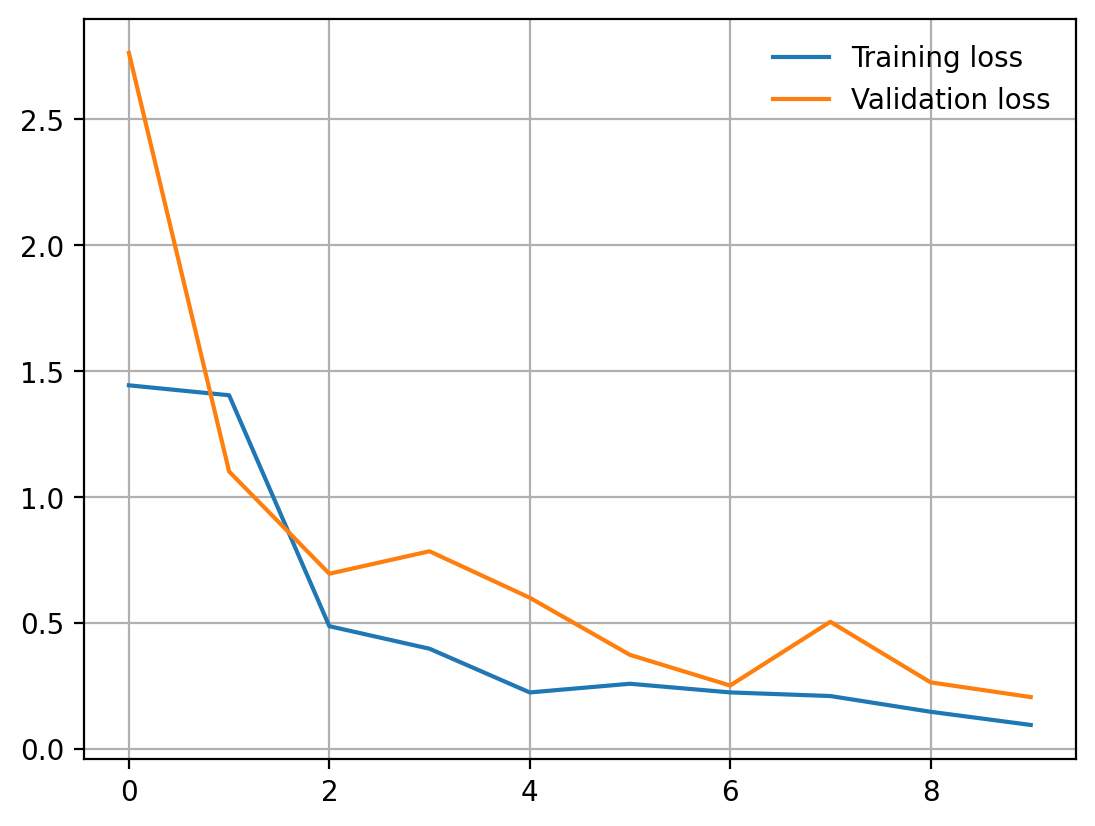

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.grid()
plt.show()

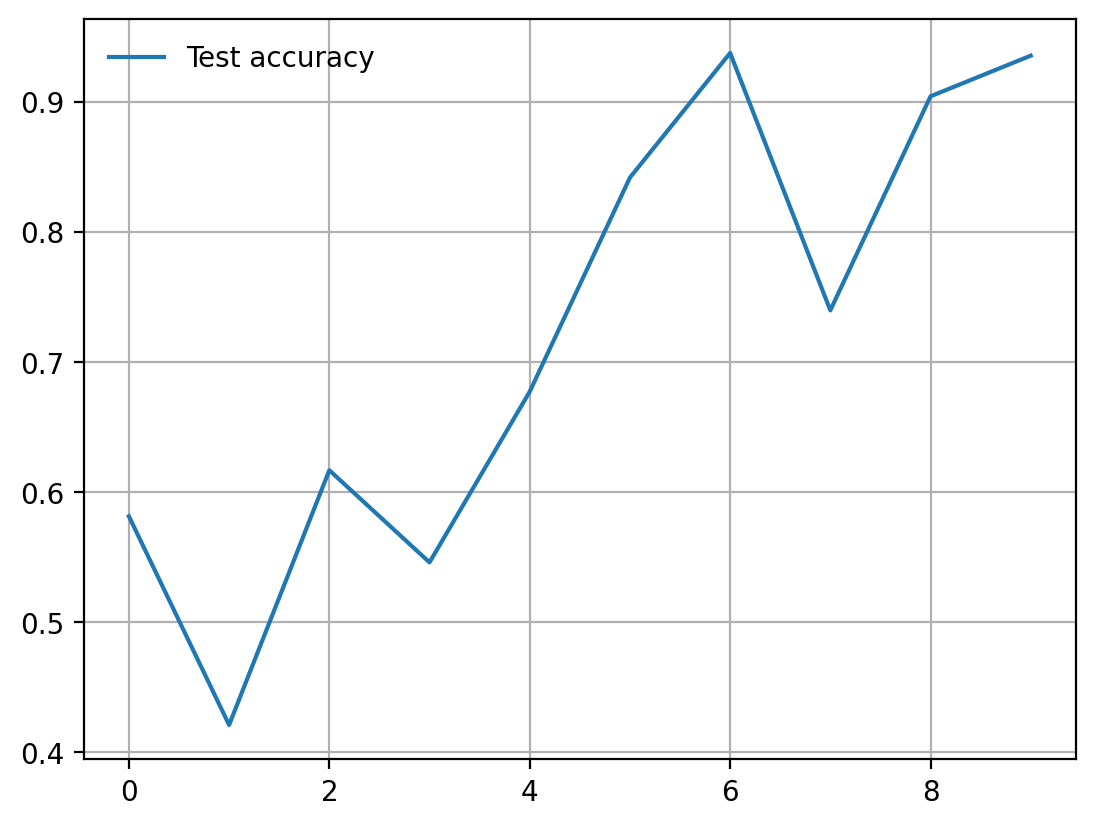

In [23]:
plt.plot(test_accuracy, label='Test accuracy')
plt.legend(frameon=False)
plt.grid()
plt.show()

나중에 다시 사용할 수 있도록 학습과 테스트가 끝난 이 모델을 저장합니다. 파이토치에서 학습한 모델은 pth라는 확장자로 저장할 수 있습니다.

In [24]:
torch.save(model, 'moonrockmodel.pth')

## 완성된 모델을 불러와 예측
저장된 모델을 불러와 예측하는 상황을 상정하겠습니다. 아까 저장한 모델을 다시 불러오는 것부터 시작합니다.

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('moonrockmodel.pth')

In [26]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 이미지 예측
예측 이미지를 사용하기 위해 `predict_image()` 함수를 작성하겠습니다.

In [27]:
def predict_image(image):
    image_tensor = t_transforms(image).float()
    input = image_tensor.unsqueeze_(0).to(device)
    output = model(input)
    index = output.data.numpy().argmax()

    return index

이제 이 함수를 이용해 5개의 이미를 임의로 가져와서 예측해보죠. 그러려면 우선 모델을 평가 모드로 전환해야 합니다.

In [28]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
classes = trainloader.dataset.classes  # 훈련용이든 테스트용이든 클래스는 동일

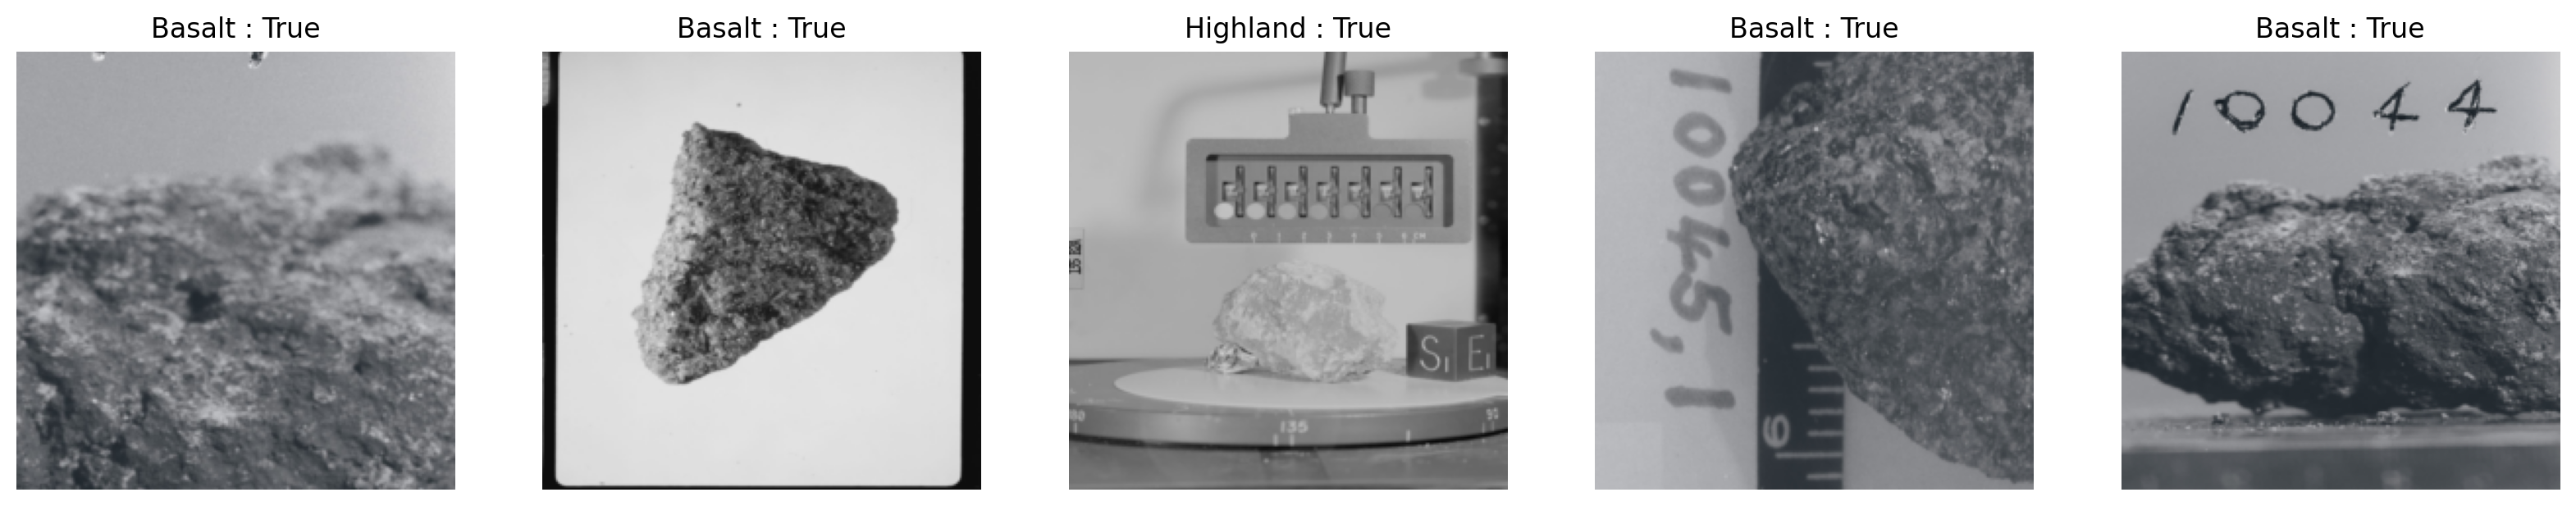

In [30]:
fig = plt.figure(figsize=(20, 20))

for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    
    sub = fig.add_subplot(1, len(images), ii + 1)
    res = labels[ii].item() == index
    sub.set_title(f"{classes[index]} : {str(res)}")
    
    plt.axis("off")
    plt.imshow(image)

plt.show()

## 재현성 확보
랜덤 시드를 고정시켜서 재현성을 확보합니다.

In [31]:
np.random.seed(42)
torch.random.manual_seed(42)

## 데이터 전처리 및 증강

In [32]:
def load_split_train_test_augmentation(data_dir, valid_size):
    # 학습용 데이터 변환 - 증강 기법 적용
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전
        transforms.RandomVerticalFlip(p=0.5),    # 상하 반전
        transforms.RandomRotation(30),           # 랜덤 회전
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 색상 변화
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet 정규화
    ])
    
    # 검증용 데이터 변환 - 기본적인 전처리만 적용
    test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet 정규화
    ])

    # 각각 다른 transform 적용
    train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

In [33]:
trainloader, testloader = load_split_train_test_augmentation(data_dir, 0.2)

In [34]:
train_losses, test_losses = [], []
test_accuracy = []

steps = 0  # 학습 단계 변수. 0으로 초기화.

In [35]:
model_aug = models.resnet50(pretrained=True)

/workspaces/spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/workspaces/spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model_aug.parameters():
    # 전이학습을 위해 모델 가중치 고정(freeze)
    param.requires_grad = False

model_aug.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

# 손실 함수 - 크로스엔트로피로 지정
criterion = nn.NLLLoss()

# 옵티마이저 - Adam
optimizer = optim.Adam(model_aug.fc.parameters(), lr=0.003)
model.to(device)
print("Done!")

Done!


In [37]:
epochs = 10
print_every = 5
running_loss = 0  # 손실 변수
train_losses, test_losses = [], []
test_accuracy = []

steps = 0  # 학습 단계 변수. 0으로 초기화.

In [38]:
print("데이터 증강 모델 훈련 시작")

for epoch in range(1, epochs + 1):
    for inputs, labels in trainloader:
        steps += 1
        print(f"Training step {steps}")
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # 기존에 학습된 그래디언트 값 초기화
        logps = model_aug.forward(inputs)  # 입력 데이터로 순전파 수행 후 로그 확률을 얻음.
        loss = criterion(logps, labels)  # 손실 계산
        loss.backward()  # 역전파 수행 → 그래디언트 업데이트
        optimizer.step()  # 파라미터 업데이트
        running_loss += loss.item()

        if steps % print_every == 0:
            # 손실과 정확도 변수를 초기화
            test_loss, accuracy = 0, 0
            # 모델을 평가 모드로 전환
            model_aug.eval()
            # 모델 평가 시 그래디언트는 계산하지 않아야 함
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model_aug.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()

                    # 로그 확률로부터 진짜 확률 계산
                    ps = torch.exp(logps)
                    # 가장 큰 확률값과 클래스를 얻음
                    ## (참고 - topk : k번째로 큰 값을 반환)
                    top_p, top_class = ps.topk(1, dim=1)
                    # 레이블들을 top_class와 동일한 형태로 바꿈
                    equals = top_class == labels.view(*top_class.shape)

                    # equlas를 float 텐서로 변환 후, 평균 정확도를 누적/계산
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # 학습 손실값 및 테스트 손실값 추가
            train_losses.append(running_loss / len(trainloader))
            test_losses.append(test_loss / len(testloader))
            test_accuracy.append(accuracy / len(testloader))
            # 학습 손실값, 테스트 손실값, 테스트 정확도 출력
            print(
                f"Epoch {epoch}/{epochs}: "
                f"Train loss: {running_loss / print_every:.3f}.. "
                f"Test loss: {test_loss / len(testloader):.3f}.. "
                f"Test accuracy: {accuracy / len(testloader):.3f}\n"
            )
            
            # 학습 손실 초기화
            running_loss = 0
            # 모델을 학습 모드로 전환
            model_aug.train()
            break

데이터 증강 모델 훈련 시작
Training step 1
Training step 2
Training step 3
Training step 4
Training step 5
Epoch 1/10: Train loss: 2.753.. Test loss: 1.546.. Test accuracy: 0.356

Training step 6
Training step 7
Training step 8
Training step 9
Training step 10
Epoch 2/10: Train loss: 1.380.. Test loss: 0.711.. Test accuracy: 0.644

Training step 11
Training step 12
Training step 13
Training step 14
Training step 15
Epoch 3/10: Train loss: 0.769.. Test loss: 0.676.. Test accuracy: 0.583

Training step 16
Training step 17
Training step 18
Training step 19
Training step 20
Epoch 4/10: Train loss: 0.593.. Test loss: 0.561.. Test accuracy: 0.646

Training step 21
Training step 22
Training step 23
Training step 24
Training step 25
Epoch 5/10: Train loss: 0.547.. Test loss: 0.727.. Test accuracy: 0.588

Training step 26
Training step 27
Training step 28
Training step 29
Training step 30
Epoch 6/10: Train loss: 0.595.. Test loss: 0.509.. Test accuracy: 0.644

Training step 31
Training step 32
Training st

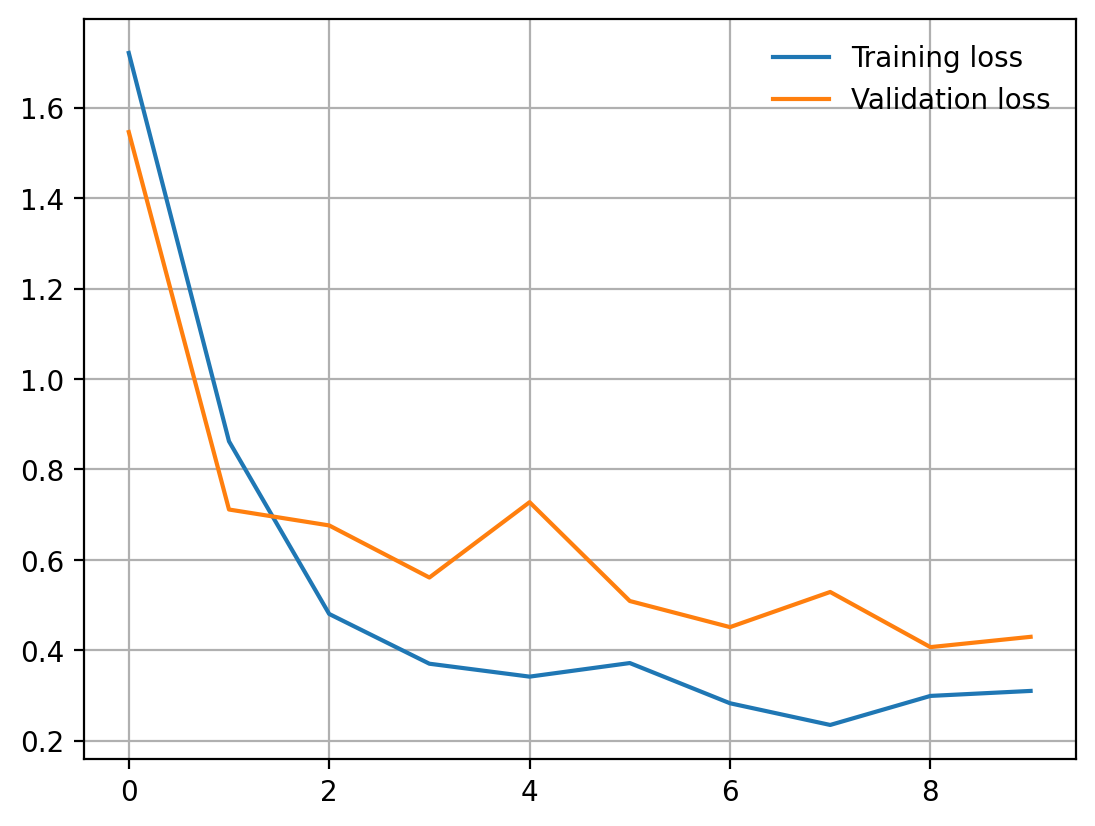

In [39]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.grid()
plt.show()

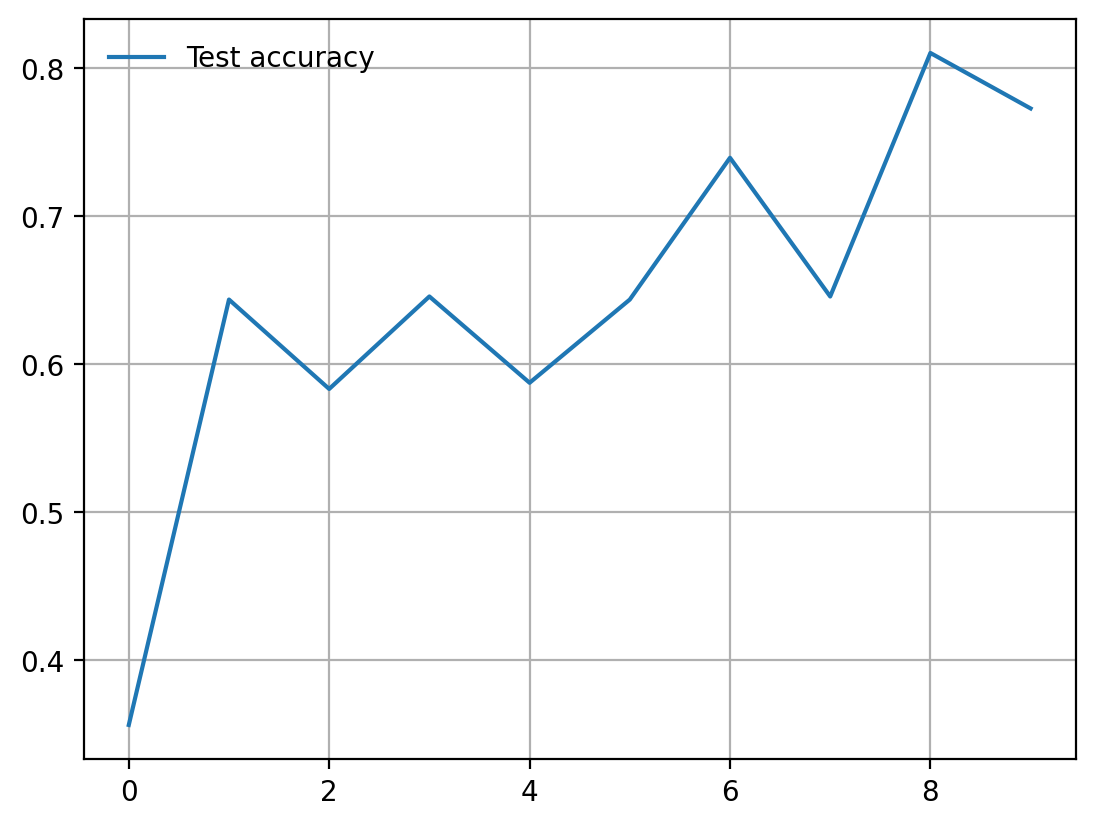

In [40]:
plt.plot(test_accuracy, label='Test accuracy')
plt.legend(frameon=False)
plt.grid()
plt.show()

In [41]:
torch.save(model_aug, 'moonrockmodel_augmented.pth')

In [42]:
model_aug.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

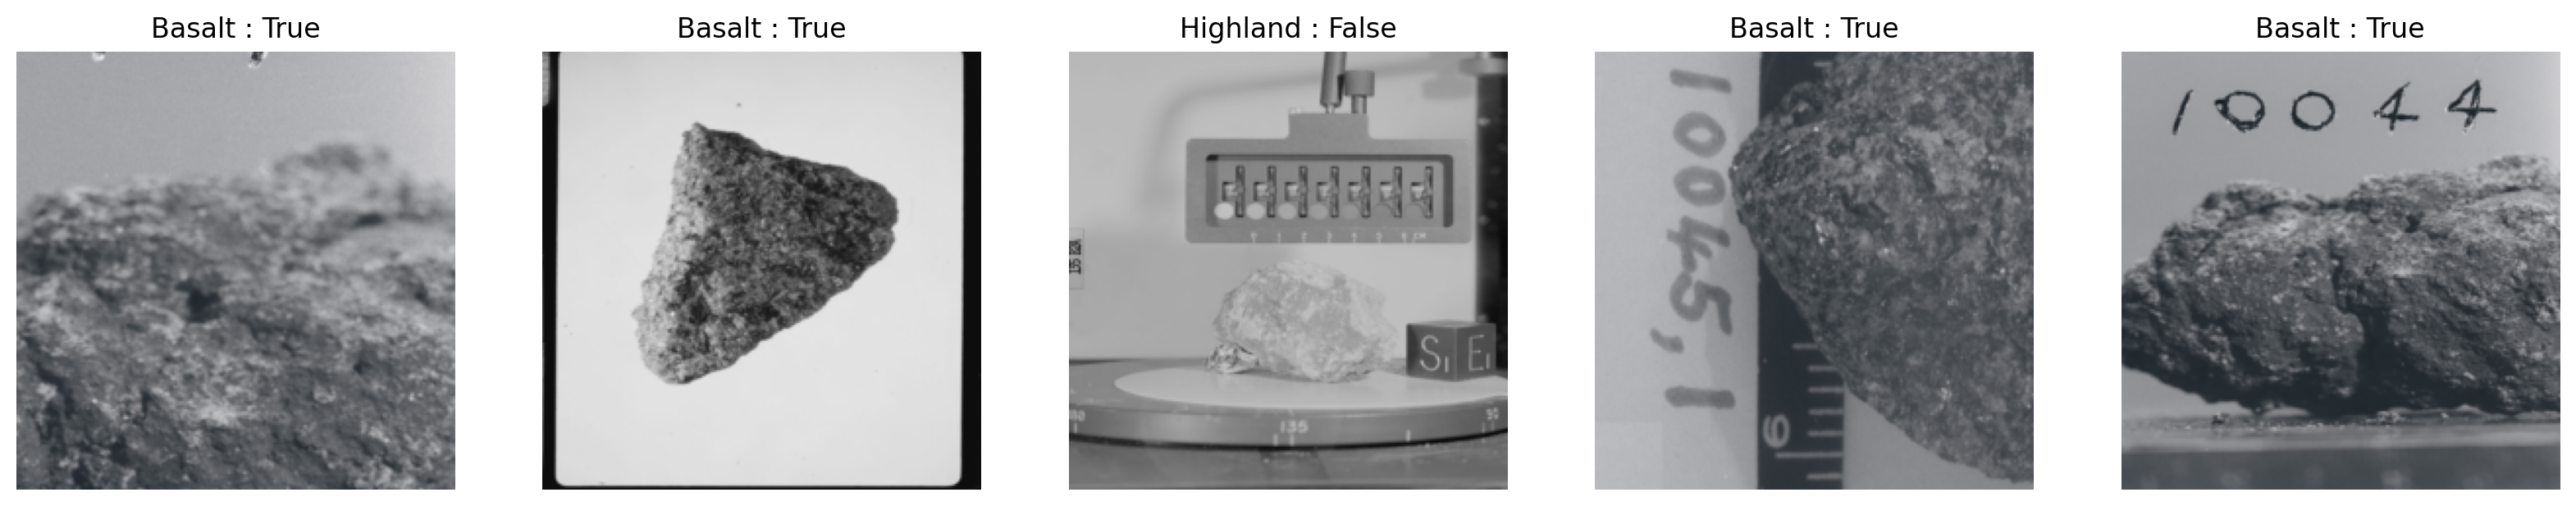

In [ ]:
fig = plt.figure(figsize=(20, 20))

for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)

    sub = fig.add_subplot(1, len(images), ii + 1)
    res = labels[ii].item() == index
    sub.set_title(f"{classes[index]} : {str(res)}")

    plt.axis("off")
    plt.imshow(image)

plt.show()